# Homework #8: Quasi-Newton Methods
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 7/14/2020|
|Updated | 7/14/2020|

## Preliminary

In [53]:
using LinearAlgebra
using Plots

In [54]:
abstract type DescentMethod end

# Rosenbrock Function

In [38]:
f(x) = (1-x[1])^2 + 5*(4x[2] - x[1]^2)^2
∇f(x) = [2*(10x[1]^3 - 40x[1]*x[2] + x[1] - 1),
         -40*(x[1]^2 - 4x[2])];

In [179]:
function rosenplot(; ticks=false, grid=false, legend=false)
    f(x, y) = (1-x)^2 + 5*(4y - x^2)^2
    x, y = -3:0.01:2, -0.5:0.01:2
    contour(x, y, f,
        size=(600, 400),
        framestyle=:box,
        color=cgrad(:viridis, rev=true),
        levels=[2,10,50,200,500],
        legend=legend,
        xlims=(-3, 2),
        ylims=(-0.5, 2),
        grid=grid,
        ticks=ticks,
        xlabel="x₁",
        ylabel="x₂")
end;

# Line Search

## (Textbook algorithm)

In [15]:
function line_search(f, x, d)
    d = normalize(d)
    objective = α -> f(x + α*d)
    v, α = f(x), 1e-6
    while f(x + α*d) < v
        v = f(x + α*d)
        α += 1e-6
    end
    return x + α*d
end;

## Strong Backtracking Approximate (Strong Wolfe Conditions)

In [16]:
function _line_search(f, ∇, x, d; α=1, β=1e-4, σ=0.1)
    """  Strong Backgracking Algorithm  """
    y0, g0, y_prev, α_prev = f(x)[1], ∇(x)⋅d, NaN, 0
    αlo, αhi = NaN, NaN
    
    # bracket phase
    while true
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev)
            αlo, αhi = α_prev, α
            break
        end
        g = ∇(x + α*d)⋅d
        if abs(g) ≤ -σ*g0
            return α
        elseif g ≥ 0
            αlo, αhi = α, α_prev
            break
        end
        y_prev, α_prev, α = y, α, 2α
    end
    
    # zoom phase
    ylo = f(x + αlo*d)[1]
    while true
        α = (αlo + αhi)/2
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || y ≥ ylo
            αhi = α
        else
            g = ∇(x + α*d)⋅d
            if abs(g) ≤ -σ*g0
                return α
            elseif g*(αhi - αlo) ≥ 0
                αhi = αlo
            end
            αlo = α
        end
    end
end;

# *Davidon-Fletcher-Powell* (DFP)

In [82]:
mutable struct DFP <: DescentMethod
    Q
end
function init!(M::DFP, f, ∇f, x)
    m = length(x)
    M.Q = Matrix(1.0I, m, m)
    return M
end
function step!(M::DFP, f, ∇f, x)
    Q, g = M.Q, ∇f(x)
    x′ = line_search(f, x, -Q*g)
    g′ = ∇f(x′)
    δ = x′ - x
    γ = g′ - g
    Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
    return x′
end;

In [83]:
x = x₀ = [-1., 1.75] # initial design point
xs_DFP = x₀'         # to store each step's x
N = 15               # max num of iterations
M = DFP(NaN)
init!(M, f, ∇f, x₀)

for i in 1:N
    x = step!(M, f, ∇f, x)
    xs_DFP = [xs_DFP; x']
end

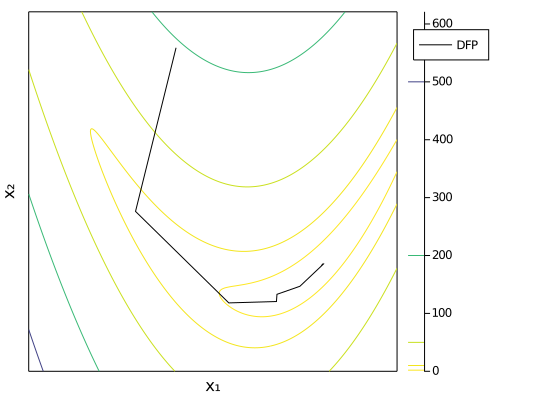

In [109]:
rosenplot(legend=true)
plot!(xs_DFP[:,1], xs_DFP[:,2], label="DFP", legend=:outertopright, color=:black)
# scatter!(xs_DFP[:,1], xs_DFP[:,2], label="", ms=2, color=:black)

# *Broyden-Fletcher-Goldfarb-Shanno* (BFGS)

In [104]:
mutable struct BFGS <: DescentMethod
    Q
end
function init!(M::BFGS, f, ∇f, x)
    m = length(x)
    M.Q = Matrix(1.0I, m, m)
    return M
end
function step!(M::BFGS, f, ∇f, x)
    Q, g = M.Q, ∇f(x)
    x′ = line_search(f, x, -Q*g)
    g′ = ∇f(x′)
    δ = x′ - x
    γ = g′ - g
    Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) +
               (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
    return x′
end;

In [105]:
x = x₀ = [-1., 1.75] # initial design point
xs_BFGS = x₀'        # to store each step's x
N = 15               # max num of iterations
M = BFGS(NaN)
init!(M, f, ∇f, x₀)

for i in 1:N
    x = step!(M, f, ∇f, x)
    xs_BFGS = [xs_BFGS; x']
end

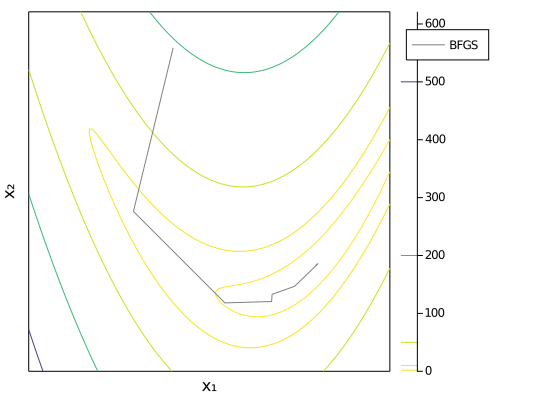

In [108]:
rosenplot(legend=true)
plot!(xs_BFGS[:,1], xs_BFGS[:,2], label="BFGS", legend=:outertopright, color=:gray)
# scatter!(xs_BFGS[:,1], xs_BFGS[:,2], label="", ms=2, color=:gray)

# *Limited-memory BFGS* (L-BFGS)

In [113]:
mutable struct LimitedMemoryBFGS <: DescentMethod
    m
    δs
    γs
    qs
end
function init!(M::LimitedMemoryBFGS, f, ∇f, x)
    M.δs = []
    M.γs = []
    M.qs = []
    return M
end
function step!(M::LimitedMemoryBFGS, f, ∇f, x)
    δs, γs, qs, g = M.δs, M.γs, M.qs, ∇f(x)
    m = length(δs)
    if m > 0
        q = g
        for i in m : -1 : 1
            qs[i] = copy(q)
            q -= (δs[i]⋅q)/(γs[i]⋅δs[i])*γs[i]
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m])
        for i in 1 : m
            z += δs[i]*(δs[i]⋅qs[i] - γs[i]⋅z)/(γs[i]⋅δs[i])
        end
        x′ = line_search(f, x, -z)
    else
        x′ = line_search(f, x, -g)
    end
    g′ = ∇f(x′)
    push!(δs, x′ - x); push!(γs, g′ - g)
    push!(qs, zeros(length(x)))
    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs)
    end
    return x′
end;

In [166]:
N = 15                   # max num of iterations
xs_LBFGS = Any[]         # to store each step's x

for m in 1:3
    x = x₀ = [-1., 1.75] # reset initial design point
    push!(xs_LBFGS, x₀')
    M = LimitedMemoryBFGS(m, NaN, NaN, NaN)
    init!(M, f, ∇f, x₀)
    for i in 1:N
        x = step!(M, f, ∇f, x)
        xs_LBFGS[m] = [xs_LBFGS[m]; x']
    end
end

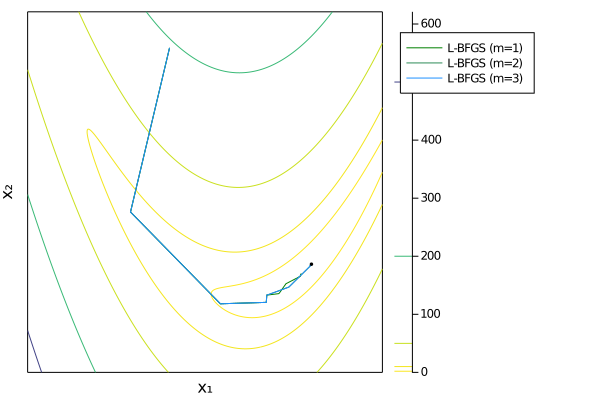

In [181]:
rosenplot(legend=true)
colors = ["green", "seagreen", "dodgerblue"]

for m in 1:3
    plot!(xs_LBFGS[m][:,1], xs_LBFGS[m][:,2], label=string("L-BFGS (m=", m, ")"), legend=:outertopright, color=colors[m])
end
scatter!([xs_LBFGS[3][end,1]], [xs_LBFGS[3][end,2]], label="", ms=2, color=:black)

# Comparison

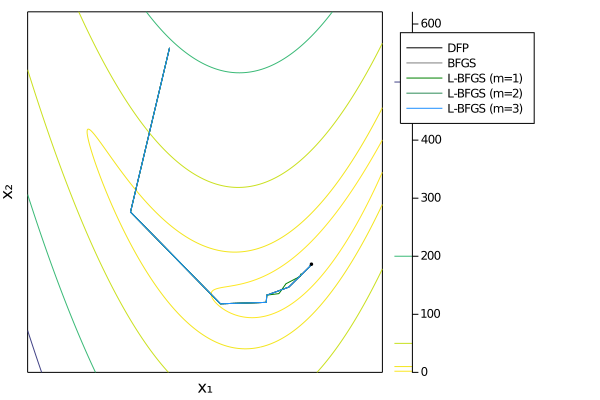

In [180]:
rosenplot(legend=true)
colors = ["green", "seagreen", "dodgerblue"]

plot!(xs_DFP[:,1], xs_DFP[:,2], label="DFP", legend=:outertopright, color=:black)
plot!(xs_BFGS[:,1], xs_BFGS[:,2], label="BFGS", legend=:outertopright, color=:gray)
for m in 1:3
    plot!(xs_LBFGS[m][:,1], xs_LBFGS[m][:,2], label=string("L-BFGS (m=", m, ")"), legend=:outertopright, color=colors[m])
end
scatter!([xs_LBFGS[3][end,1]], [xs_LBFGS[3][end,2]], label="", ms=2, color=:black)